In [28]:
!pip install wfdb --quiet
!pip install keras-tuner --quiet
!pip install resnet1d --quiet
!pip install tqdm --quiet

ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


In [29]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [30]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [31]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [32]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A','/']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [33]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [34]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    
    time = np.arange(len(signal)) / fs 
    if mask.ndim == 1:
        num_classes = 4  
        mask = np.eye(num_classes)[mask]  

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [36]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    window_size = 240
    stride = window_size // 4  
    
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)

    indices = np.where(mask[:, 0] != 1)[0] 
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    

    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)


    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  


    segments = np.expand_dims(segments, axis=1) 


    masks = np.argmax(masks, axis=-1)            

    return segments, masks


In [37]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  
path='/kaggle/input/qtdb-ludb/'
qtdb_path = path + "physionet.org/files/qtdb/1.0.0/"
ludb_path = path + "physionet.org/files/ludb/1.0.1/data/"


qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:14<00:00,  7.17it/s]


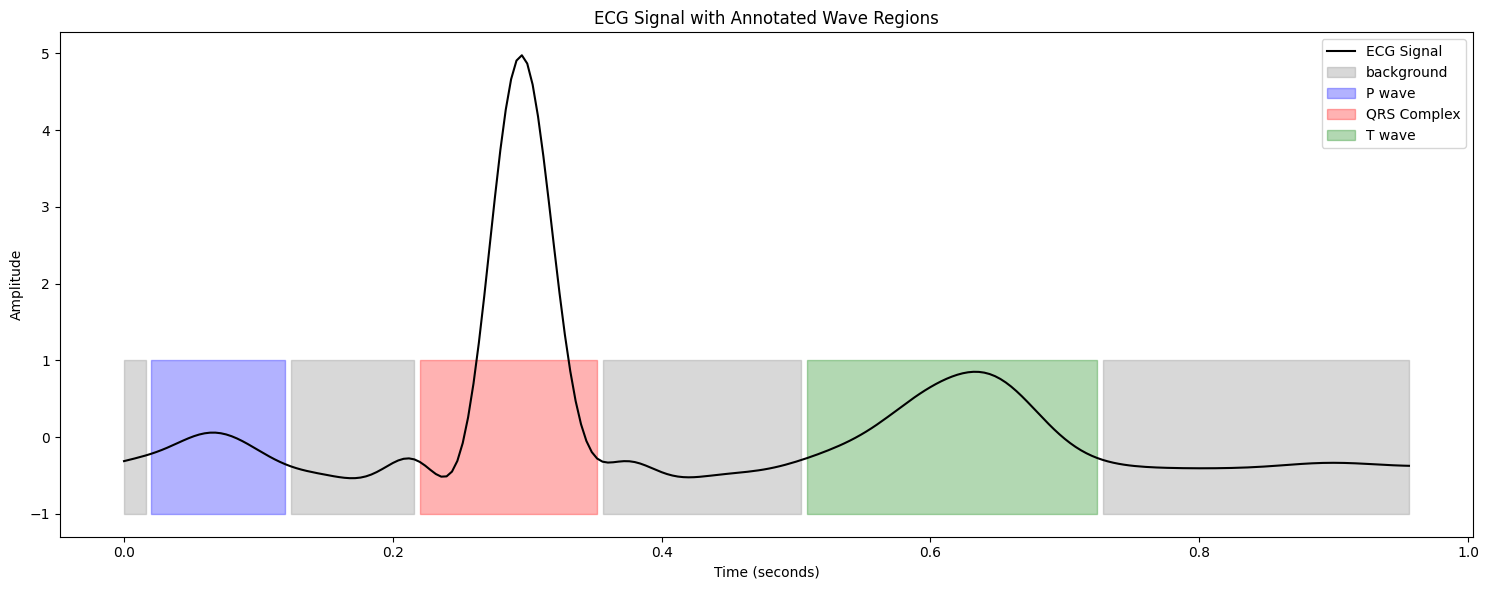

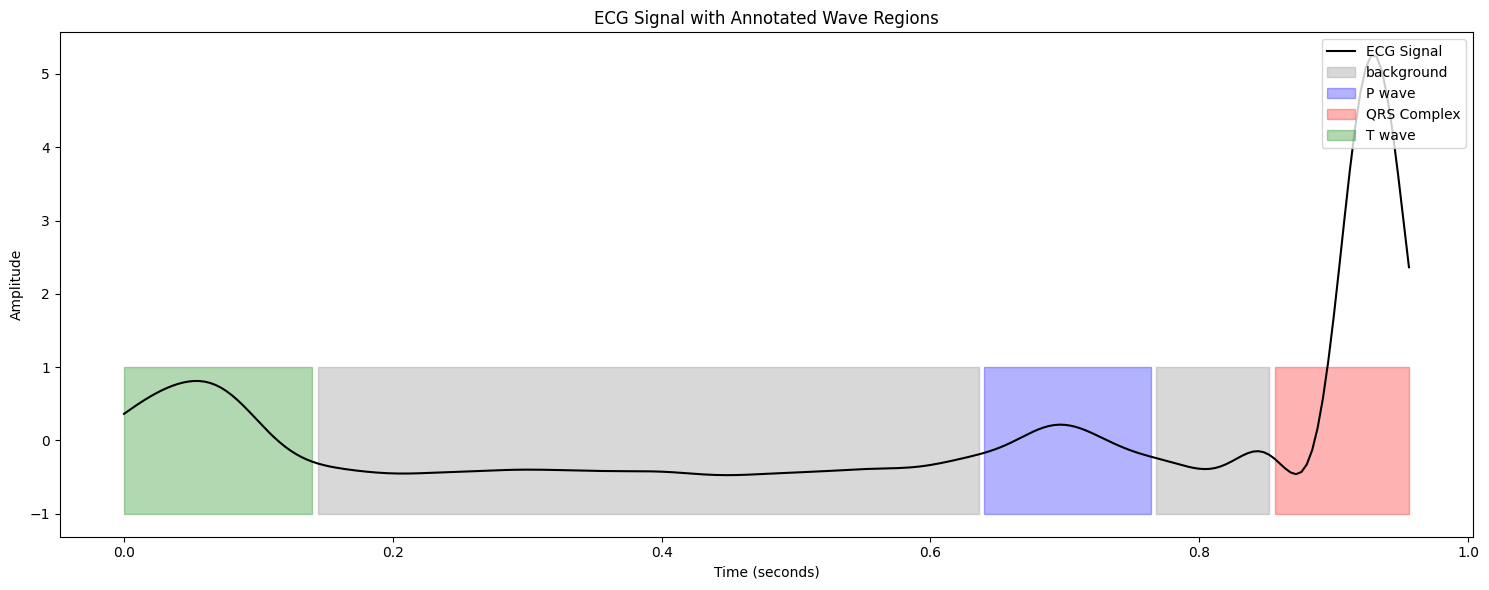

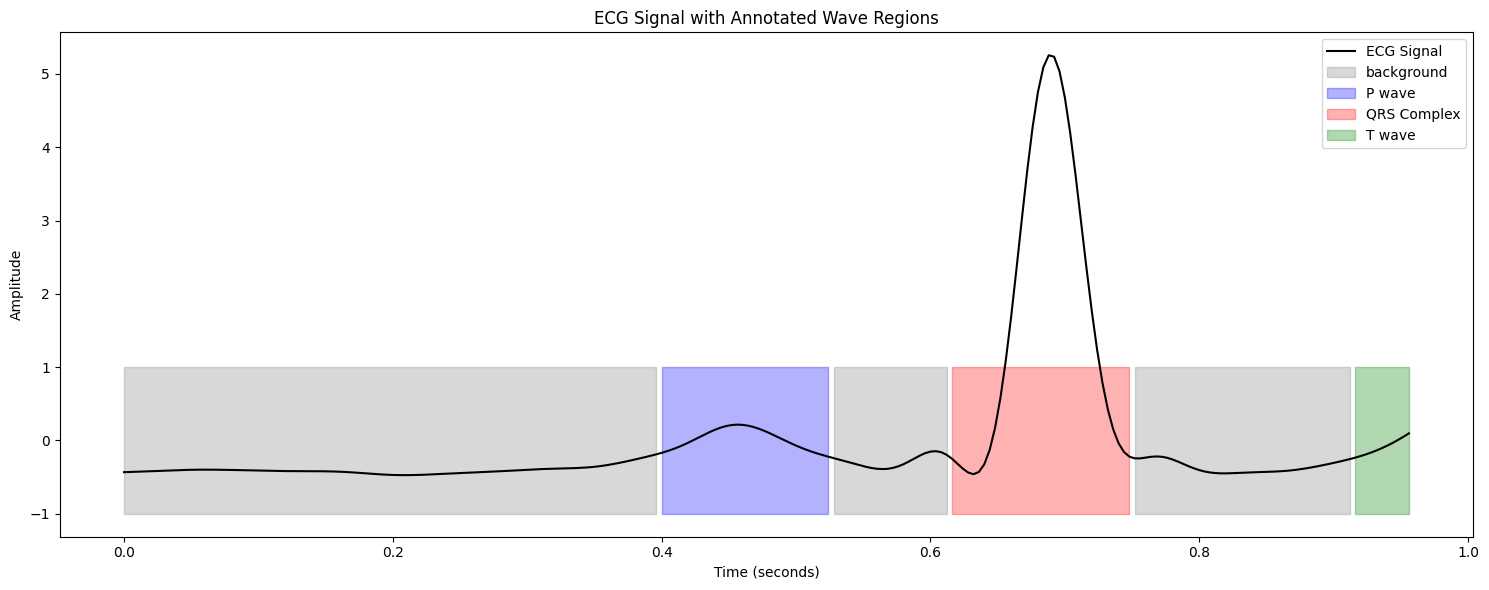

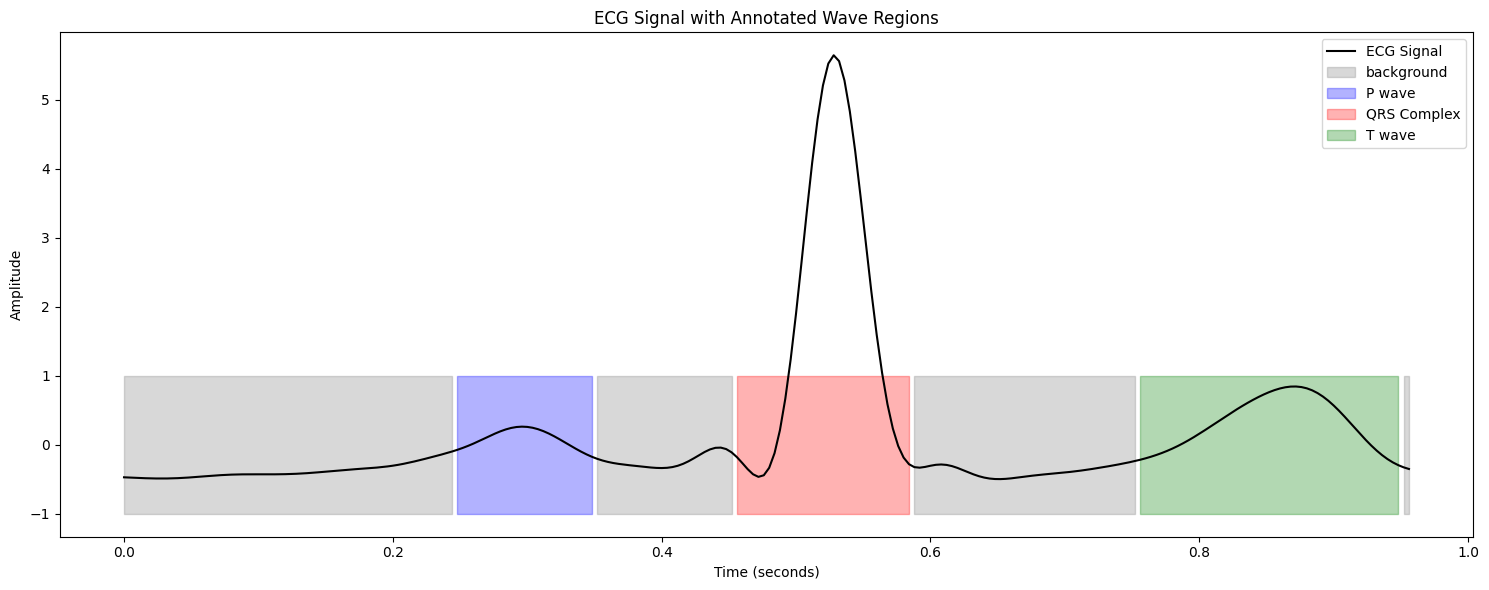

In [38]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"
    try:

        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)

    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])



Processing LUDB Records: 100%|██████████| 200/200 [00:01<00:00, 100.35it/s]


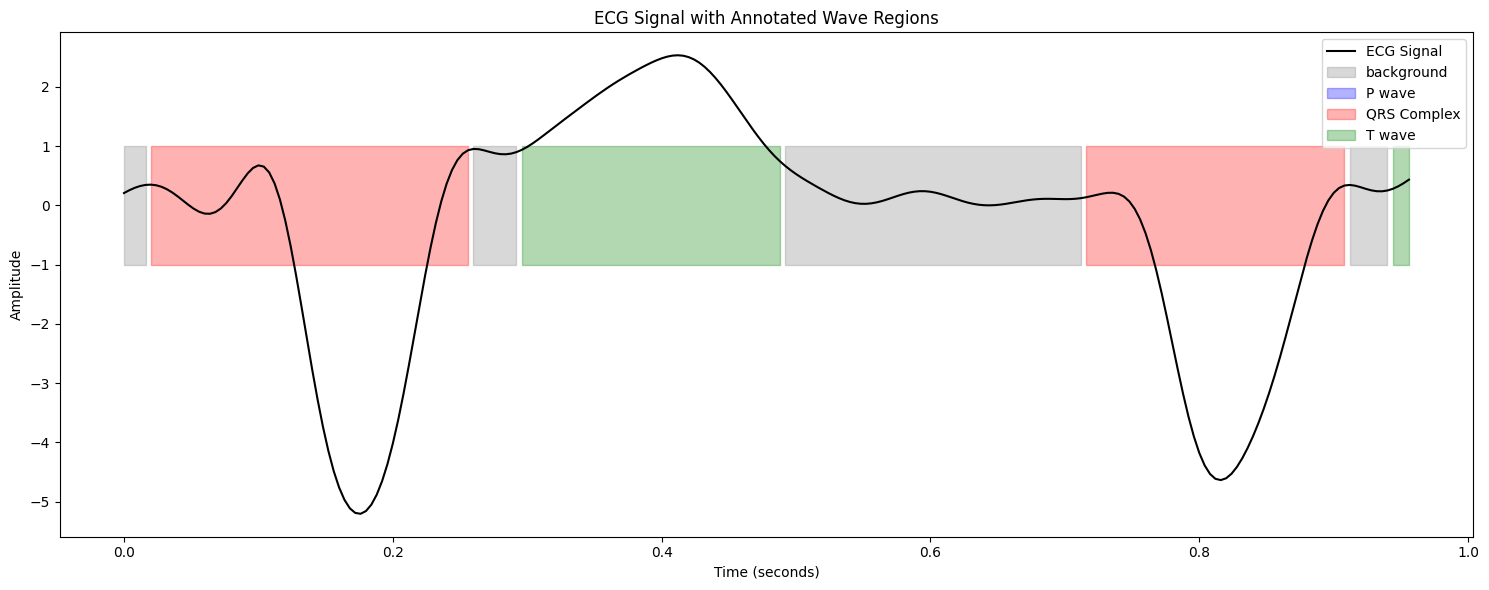

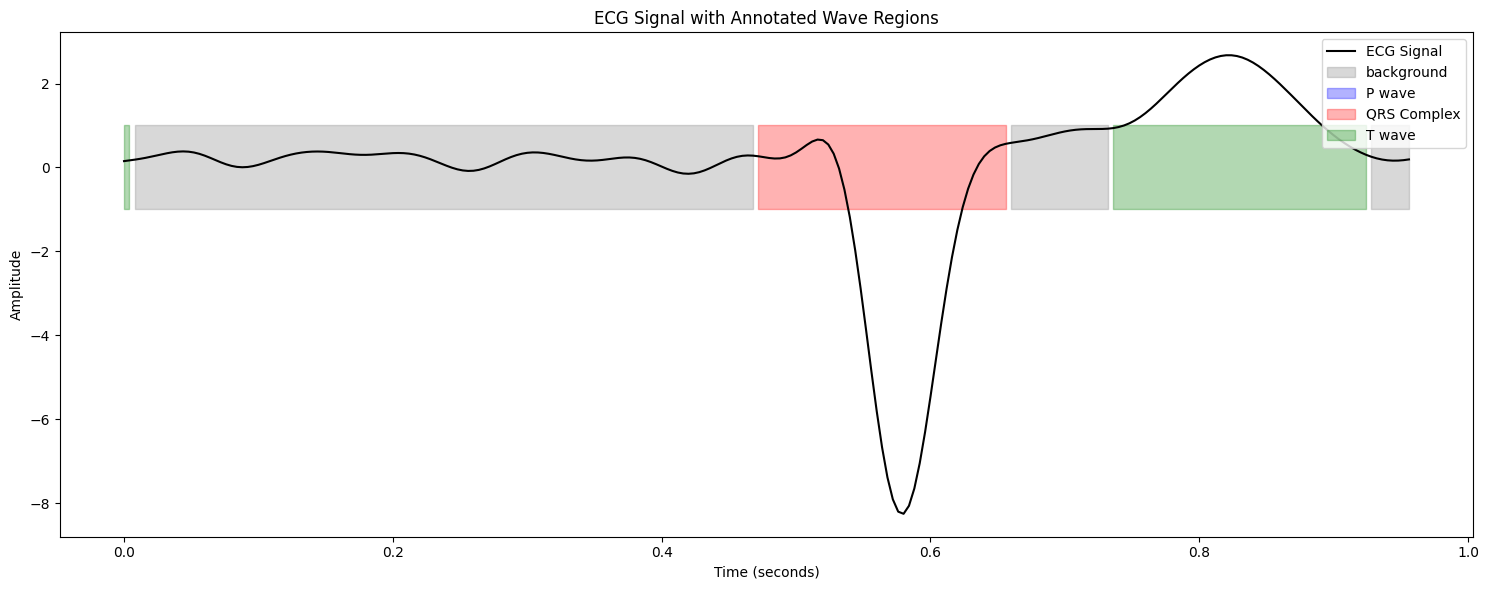

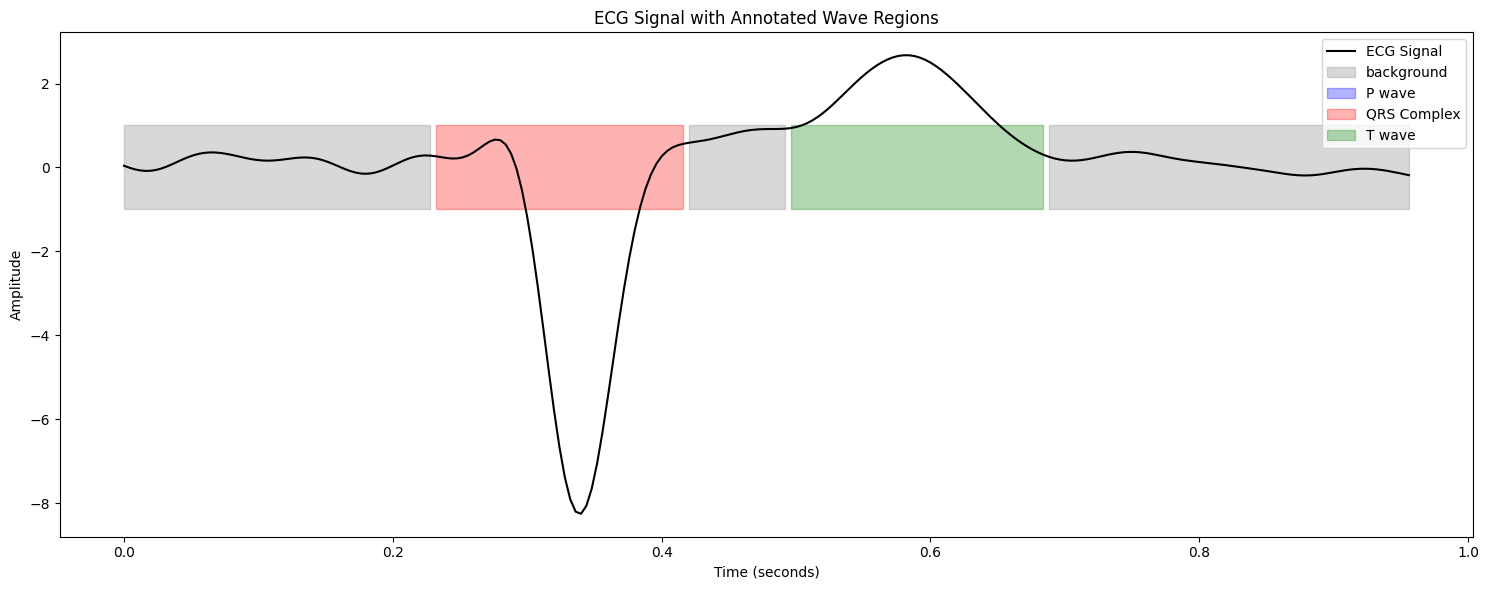

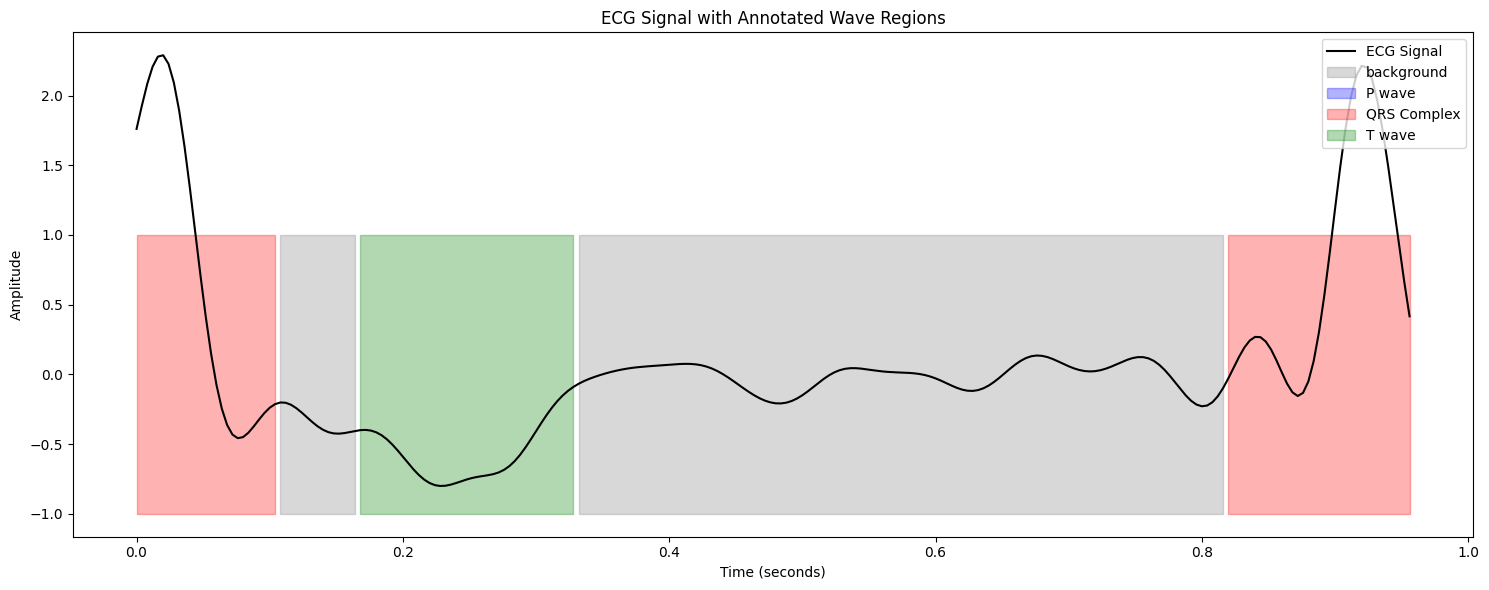

In [39]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:

        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)

    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")




display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [40]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [41]:

X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [42]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 3 3 3]
 ...
 [3 3 3 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 2 2 ... 2 2 2]]


In [43]:
import numpy as np

flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)
from re import S
import os
# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {0: 45861096, 1: 9742522, 2: 17298084, 3: 22661258}
Class Weights (Relative Frequency): {0: 0.47990451530593026, 1: 0.10194872574060075, 2: 0.1810124341062688, 3: 0.2371343248472002}
Weight of Class 0: 0.4799


In [44]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [46]:
from torch.utils.data import Dataset, DataLoader

class ECGWaveformDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.long)

train_dataset = ECGWaveformDataset(X_train, y_train)
val_dataset = ECGWaveformDataset(X_val, y_val)
test_dataset = ECGWaveformDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [47]:
X=None
y=None

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out

def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [49]:
import torch
import random
import torch.nn.functional as F

class ECGAugment:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        
        if len(x.shape) != 3:
            raise ValueError(f"Expected 3D input (B,1,L), got {x.shape}")
        if len(y.shape) != 2:
            raise ValueError(f"Expected 2D mask (B,L), got {y.shape}")

        batch_size, _, seq_len = x.shape

        # Random scaling
        if random.random() < self.p:
            scale = torch.empty(batch_size, 1, 1).uniform_(0.9, 1.1).to(x.device)
            x = x * scale

        # Add Gaussian noise
        if random.random() < self.p:
            x = x + torch.randn_like(x) * 0.01

        # Random time warping
        if random.random() < self.p:
            new_len = random.randint(int(seq_len*0.95), int(seq_len*1.05))

            # Reshape for interpolation (B,1,L) -> (B*1,L) -> (B*1,1,L)
            x_reshaped = x.view(-1, seq_len).unsqueeze(1)
            x_warped = F.interpolate(x_reshaped, size=new_len,
                                   mode='linear', align_corners=True)
            x_warped = F.interpolate(x_warped, size=seq_len,
                                   mode='linear', align_corners=True)
            x = x_warped.view(batch_size, 1, seq_len)

            # Reshape mask (B,L) -> (B,1,L)
            y_reshaped = y.float().unsqueeze(1)
            y_warped = F.interpolate(y_reshaped, size=new_len,
                                   mode='nearest')
            y_warped = F.interpolate(y_warped, size=seq_len,
                                   mode='nearest')
            y = y_warped.squeeze(1).long()

        return x, y

In [50]:
def compute_per_class_loss(output, target, num_classes=4):
    """ Compute loss per class for analysis. """
    per_class_loss = torch.zeros(num_classes, device=device)
    log_probs = F.log_softmax(output, dim=1)  # Convert output to log probabilities

    for cls in range(num_classes):
        mask = (target == cls)  # Mask for class cls
        if mask.sum() > 0:  # Avoid empty class issue
            cls_loss = -log_probs[:, cls, :][mask].mean()  # Compute log loss
            per_class_loss[cls] = cls_loss

    return per_class_loss

def compute_loss_and_metrics(output, target):
    """Compute focal loss and metrics"""
    # Focal loss calculation
    log_probs = F.log_softmax(output, dim=1)
    probs = torch.exp(log_probs)

    # Gather the probabilities of the target classes
    target_probs = probs.gather(1, target.unsqueeze(1)).squeeze(1)
    focal_term = -((1 - target_probs) ** 2.0) * log_probs.gather(1, target.unsqueeze(1)).squeeze(1)

    # Apply class weights
    weights = class_weights.gather(0, target.view(-1)).view_as(focal_term)
    loss = (focal_term * weights).mean()

    # Per-class loss
    per_class_loss = torch.zeros(4, device=device)
    for cls in range(4):
        mask = (target == cls)
        if mask.sum() > 0:
            per_class_loss[cls] = focal_term[mask].mean()

    # Metrics calculation
    preds = torch.argmax(output, dim=1)
    acc = (preds == target).float().mean()

    # Per-class IoU
    ious = torch.zeros(4, device=device)
    for cls in range(4):
        intersection = ((preds == cls) & (target == cls)).sum()
        union = ((preds == cls) | (target == cls)).sum()
        ious[cls] = intersection / (union + 1e-8)

    return loss, per_class_loss, acc.item(), ious


In [51]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert inputs to probabilities
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Gather the probabilities of the target classes
        B, C, L = inputs.shape
        targets = targets.unsqueeze(1)  # (B, 1, L)
        class_probs = probs.gather(1, targets).squeeze(1)  # (B, L)

        # Compute focal loss
        focal = -((1 - class_probs) ** self.gamma) * log_probs.gather(1, targets).squeeze(1)

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_weight = self.alpha.gather(0, targets.view(-1)).view_as(focal)
            focal = focal * alpha_weight

        # Reduce loss
        if self.reduction == 'mean':
            return focal.mean()
        elif self.reduction == 'sum':
            return focal.sum()
        else:
            return focal

In [52]:
import torch.nn as nn
import torch.optim as optim



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet1D_Enhanced(n_classes=4).to(device)

augmenter = ECGAugment(p=0.5)  

class_weights = torch.tensor([0.3, 0.3, 0.25, 0.15], device=device)
best_weights = class_weights.clone()
best_val_loss = float('inf')

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [53]:
def update_weights(val_class_loss, momentum=0.8, min_weight=0.1):
    """Update class weights with stability controls"""
    global class_weights, best_weights, best_val_loss

    # Calculate new weights
    new_weights = val_class_loss / val_class_loss.sum()
    new_weights = torch.clamp(new_weights, min_weight, 1.0)  # Constrain weights
    new_weights = new_weights / new_weights.sum()  # Renormalize

    # Apply momentum
    class_weights = momentum * class_weights + (1 - momentum) * new_weights

    # Save best weights
    current_val_loss = val_class_loss.mean()
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_weights = class_weights.clone()


In [54]:
def train_epoch(train_loader):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_ious = torch.zeros(4, device=device)

    for X_batch, y_batch in tqdm(train_loader, desc="Training"):
        # Ensure proper dimensions
        if len(X_batch.shape) == 2:  # (B,L) -> (B,1,L)
            X_batch = X_batch.unsqueeze(1)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Apply augmentations
        X_batch, y_batch = augmenter(X_batch, y_batch)

        optimizer.zero_grad()
        output = model(X_batch)  # (B,4,L)

        # Compute loss and metrics
        loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_ious += ious

    return epoch_loss/len(train_loader), epoch_acc/len(train_loader), epoch_ious/len(train_loader)

def evaluate(val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    val_ious = torch.zeros(4, device=device)
    val_class_loss = torch.zeros(4, device=device)

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

            val_loss += loss.item()
            val_acc += acc
            val_ious += ious
            val_class_loss += class_loss * len(X_batch)

    avg_class_loss = val_class_loss / len(val_loader.dataset)
    return (val_loss/len(val_loader), val_acc/len(val_loader),
            val_ious/len(val_loader), avg_class_loss)

In [ ]:
def train(train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    val_class_losses = []
    class_weights_history = []


    for epoch in range(epochs):
        train_loss, train_acc, train_iou = train_epoch(train_loader)
        val_loss, val_acc, val_iou, val_class_loss = evaluate(val_loader)

        scheduler.step(val_loss)
        update_weights(val_class_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_ious.append(train_iou.cpu().numpy())
        val_ious.append(val_iou.cpu().numpy())
        val_class_losses.append(val_class_loss.cpu().numpy())
        class_weights_history.append(class_weights.cpu().numpy())


        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou.cpu().numpy()}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou.cpu().numpy()}")
        print(f"Class Losses: {val_class_loss.cpu().numpy()}")
        print(f"Class Weights: {class_weights.cpu().numpy()}")

    return train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, val_class_losses, class_weights_history

In [ ]:
train_history = train(train_loader, val_loader, epochs=20)

In [ ]:
train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, val_class_losses, class_weights_history = train_history

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accs, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot per-class IoU
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(epochs, [iou[i] for iou in train_ious], 'o-', label=f'Train IoU Class {i}')
    plt.plot(epochs, [iou[i] for iou in val_ious], 'x-', label=f'Val IoU Class {i}')
plt.title('Training and Validation IoU per Class')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

# Plot per-class loss
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(epochs, [loss[i] for loss in val_class_losses], 'o-', label=f'Val Loss Class {i}')
plt.title('Validation Loss per Class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot class weights history
plt.figure(figsize=(12, 6))
class_labels = ['BG', 'P', 'QRS', 'T']
for i in range(4):
    plt.plot(epochs, [weights[i] for weights in class_weights_history], 'o-', label=f'Class {i} ({class_labels[i]})')
plt.title('Class Weights History')
plt.xlabel('Epochs')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.show()

In [55]:


import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytorch/default/1/updated_unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()

model = model_deep

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_ious = torch.zeros(4, device=device)
    test_class_loss = torch.zeros(4, device=device)

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            if len(X_batch.shape) == 2:
                X_batch = X_batch.unsqueeze(1)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Handle label shape
            if y_batch.dim() == 3 and y_batch.shape[-1] > 1:
                y_batch = y_batch.argmax(dim=2)

            output = model(X_batch)
            loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

            test_loss += loss.item()
            test_acc += acc
            test_ious += ious
            test_class_loss += class_loss * len(X_batch)

            # === Visualization ===
            if i == 0:
                signal = X_batch[0, 0].cpu().numpy()
                pred_mask = output.argmax(dim=1)[0].cpu().numpy()
                true_mask = y_batch[0].cpu().numpy()
                time = np.arange(len(signal))

                plt.figure(figsize=(15, 6))
                plt.plot(time, signal, color='black', label='ECG Signal')

                for class_idx, color, label in zip([1, 2, 3], ['blue', 'red', 'green'], ['P', 'QRS', 'T']):
                    plt.fill_between(time, -1, 1, where=pred_mask == class_idx, color=color, alpha=0.3, label=f'Predicted {label}')
                    plt.fill_between(time, -1, 1, where=true_mask == class_idx, color=color, alpha=0.1, label=f'True {label}', linestyle='dashed')

                plt.title('Predicted vs Ground Truth Mask on Test Sample')
                plt.xlabel('Time (samples)')
                plt.ylabel('Amplitude')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()

    avg_loss = test_loss / len(test_loader)
    avg_acc = test_acc / len(test_loader)
    avg_ious = test_ious / len(test_loader)
    avg_class_loss = test_class_loss / len(test_loader.dataset)

    print("\n📊 Test Results:")
    print(f"Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f} | IoUs: {avg_ious.cpu().numpy()}")
    print(f"Class-wise Losses: {avg_class_loss.cpu().numpy()}")

    return avg_loss, avg_acc, avg_ious.cpu().numpy(), avg_class_loss.cpu().numpy()


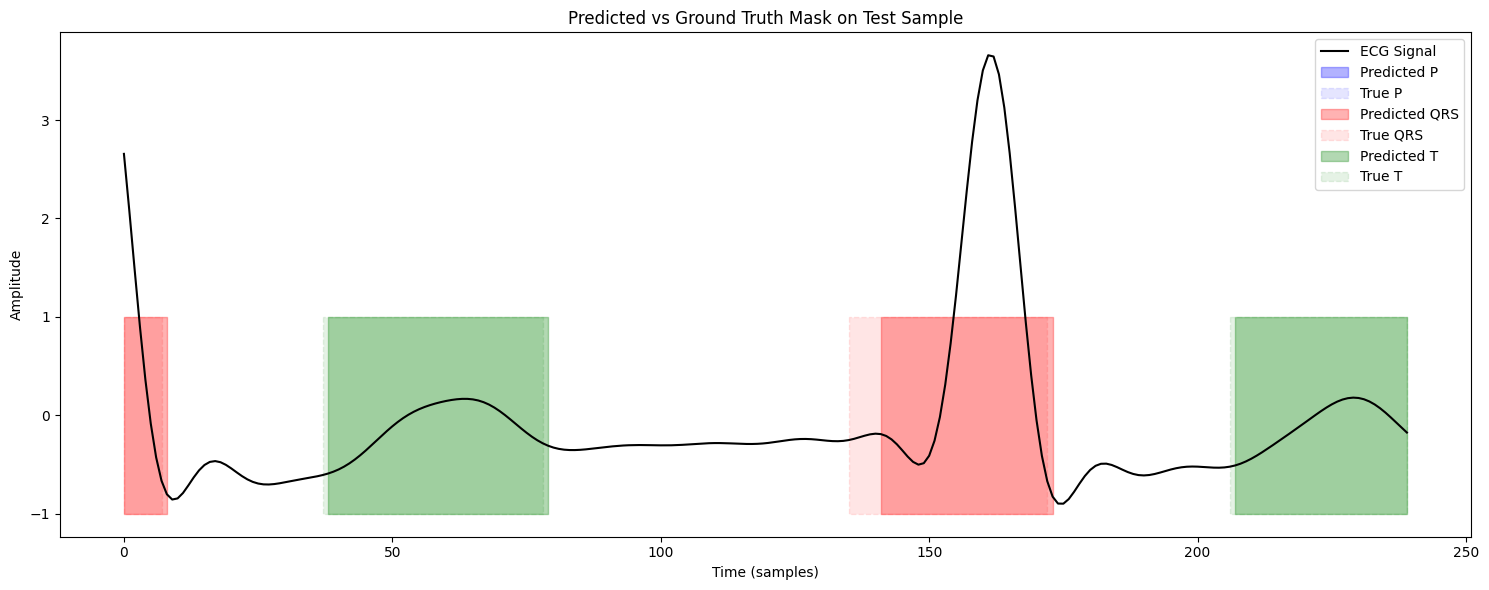


📊 Test Results:
Loss: 0.0107 | Accuracy: 0.9413 | IoUs: [0.8886804  0.8366943  0.93067425 0.8838422 ]
Class-wise Losses: [0.04107047 0.05122155 0.03830672 0.04231893]


(0.010745755750327154,
 0.9413390838889402,
 array([0.8886804 , 0.8366943 , 0.93067425, 0.8838422 ], dtype=float32),
 array([0.04107047, 0.05122155, 0.03830672, 0.04231893], dtype=float32))

In [57]:
test(model, test_loader)


In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 1, 240)) 

In [ ]:
!pip install torchviz --quiet

In [ ]:
torch.save(model, "full_unet1d_ecg_qrs_model.pth")


In [ ]:
torch.save(model.state_dict(), "updated_unet1d_ecg_qrs.pth")


# testing model on ecg signal

In [ ]:
model = UNet1D_Enhanced(n_classes=4)
model.load_state_dict(torch.load("/kaggle/working/updated_unet1d_ecg_qrs.pth", map_location=device))
model.to(device)
model.eval()


In [ ]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    target_fs = 250
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [ ]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


In [ ]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/104')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

In [ ]:


#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

In [ ]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

In [ ]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/223')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))